In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
DATA_DIR = "../../data2/processed224"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")

IMG_SIZE  = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6
LR_INIT   = 1e-4

# Régularisation L2
l2_conv  = 0.0005
l2_dense = 0.001

# Label Smoothing
LABEL_SMOOTHING = 0.1


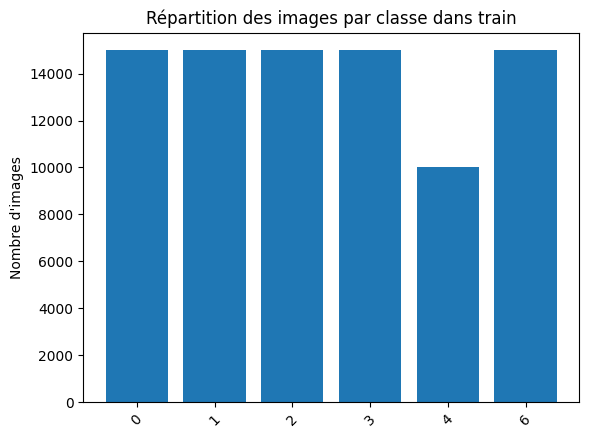

{'0': 15000, '1': 15000, '2': 15000, '3': 15000, '4': 10000, '6': 15000}


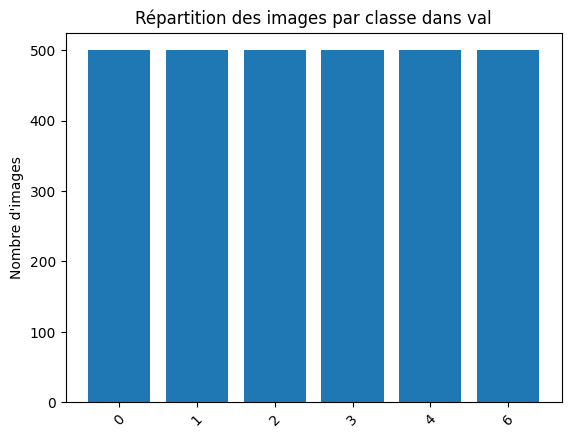

{'0': 500, '1': 500, '2': 500, '3': 500, '4': 500, '6': 500}


In [13]:
data_path = "../../data2/processed/train"
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in os.listdir(data_path)}

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe dans train")
plt.show()

print(class_counts)

data_path = "../../data2/processed/val"
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in os.listdir(data_path)}

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe dans val")
plt.show()

print(class_counts)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 85000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


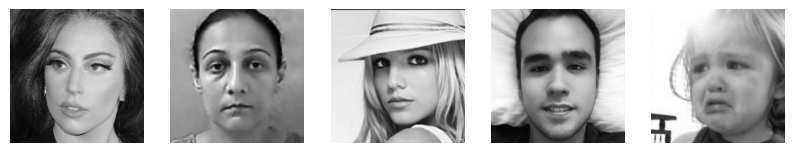

In [15]:
images, labels = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(5): 
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
class SqueezeExciteBlock(layers.Layer):
    def __init__(self, filters, ratio=16):
        super().__init__()
        self.gap = layers.GlobalAveragePooling2D(keepdims=True)
        self.dense1 = layers.Dense(filters // ratio, activation='relu')
        self.dense2 = layers.Dense(filters, activation='sigmoid')

    def call(self, inputs):
        x = self.gap(inputs)       # shape (batch,1,1,filters)
        x = self.dense1(x)         # shape (batch,1,1,filters//ratio)
        x = self.dense2(x)         # shape (batch,1,1,filters)
        return inputs * x          # scale feature maps

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=(224, 224, 1)),

    # Bloc 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_regtularizer=regularizers.l2(l2_conv)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_conv)),
    layers.BatchNormalization(),
    # SqueezeExciteBlock(filters=64, ratio=16),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    # Bloc 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_conv)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_conv)),
    layers.BatchNormalization(),
    SqueezeExciteBlock(filters=128, ratio=16),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    # Bloc 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_conv)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_conv)),
    layers.BatchNormalization(),
    SqueezeExciteBlock(filters=256, ratio=32),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    # Bloc 4
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_conv)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_conv)),
    layers.BatchNormalization(),
    # SqueezeExciteBlock(filters=512, ratio=16),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l2_dense)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_dense)),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [18]:
loss_fn = CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR_INIT),
    loss=loss_fn,
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
2657/2657 [==============================] - 554s 208ms/step - loss: 4.4543 - accuracy: 0.1756 - val_loss: 3.4289 - val_accuracy: 0.1583 - lr: 1.0000e-04
Epoch 2/50
2657/2657 [==============================] - 550s 207ms/step - loss: 2.8918 - accuracy: 0.1801 - val_loss: 2.6300 - val_accuracy: 0.1880 - lr: 1.0000e-04
Epoch 3/50
2657/2657 [==============================] - 880s 331ms/step - loss: 2.1815 - accuracy: 0.3522 - val_loss: 1.8659 - val_accuracy: 0.4637 - lr: 1.0000e-04
Epoch 4/50
2657/2657 [==============================] - 544s 205ms/step - loss: 1.6790 - accuracy: 0.5070 - val_loss: 1.6496 - val_accuracy: 0.5387 - lr: 1.0000e-04
Epoch 5/50
2657/2657 [==============================] - 529s 199ms/step - loss: 1.5193 - accuracy: 0.5722 - val_loss: 1.5263 - val_accuracy: 0.5783 - lr: 1.0000e-04
Epoch 6/50
2657/2657 [==============================] - 531s 200ms/step - loss: 1.4538 - accuracy: 0.5982 - val_loss: 1.5303 - val_accuracy: 0.5960 - lr: 1.0000e-04
Epoch 7/50

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

94/94 [==============================] - 5s 46ms/step - loss: 1.4360 - accuracy: 0.6407
Test Accuracy: 0.64


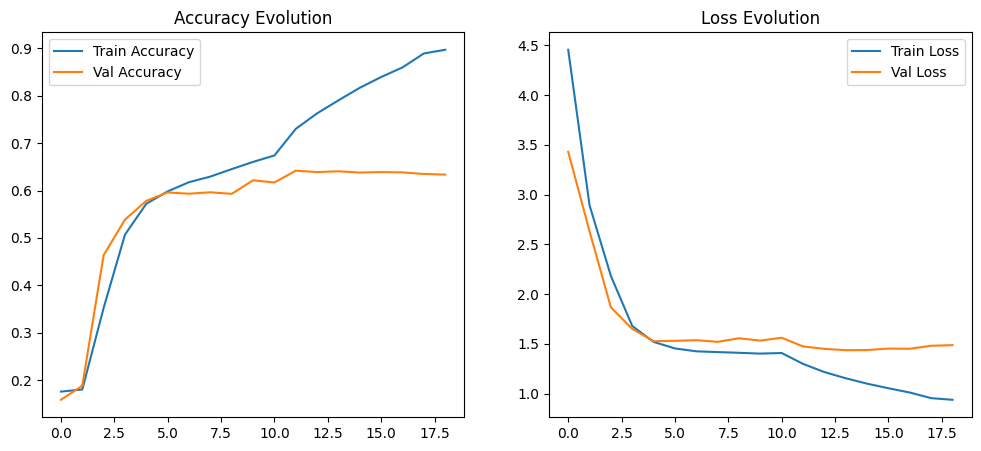

In [22]:
# 🔹 Évaluation
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# 🔹 Courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')

plt.show()

1/1 [==============================] - 0s 163ms/step


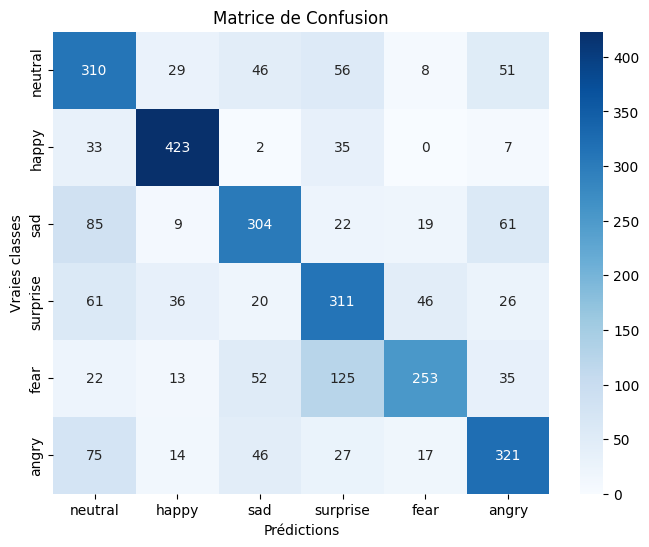

Classification Report:
              precision    recall  f1-score   support

     neutral       0.53      0.62      0.57       500
       happy       0.81      0.85      0.83       500
         sad       0.65      0.61      0.63       500
    surprise       0.54      0.62      0.58       500
        fear       0.74      0.51      0.60       500
       angry       0.64      0.64      0.64       500

    accuracy                           0.64      3000
   macro avg       0.65      0.64      0.64      3000
weighted avg       0.65      0.64      0.64      3000



In [ ]:
y_true = []
y_pred = []

for batch in val_generator:
    X_batch, y_batch = batch
    y_true.extend(np.argmax(y_batch, axis=1)) 
    y_pred.extend(np.argmax(model.predict(X_batch), axis=1))

    if len(y_true) >= val_generator.samples:
        break

class_labels = list(val_generator.class_indices.keys())
label_names = ["neutral", "happy", "sad", "surprise", "fear", "angry"]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

In [24]:
model.save("scratch_d2_64_attention.h5")

NotImplementedError: 
Layer SqueezeExciteBlock has arguments ['filters', 'ratio']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config